# Import moduls

In [64]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# moduls for img_preprocessing()
from PIL import Image

# moduls for KMeans_color()
from sklearn.cluster import MiniBatchKMeans
from collections import Counter

# modul for check_silhouette()
from sklearn.metrics import silhouette_score, silhouette_samples

# modul for color_identify_distance()
from math import dist

# Functions

In [3]:
def img_preprocessing(img):
    img = img.convert("RGBA")
    img = img.resize((128, 128))
    datas = img.getdata()
    
    newData = []
    cutoff = 200
    
    # cutoff 
    for item in datas:
        if item[0] >= cutoff and item[1] >= cutoff and item[2] >= cutoff:
            newData.append((255, 255, 255, 0)) # if RGB value is over cutoff, consider as background (white)
        else:
            newData.append(item)  # don't change others

    img.putdata(newData)
    plt.imshow(img)
    
    img_pixel = pd.DataFrame(np.array(newData))
    drop_idx = img_pixel[img_pixel[3] == 0].index  # if pixel is transparent, dorp
    img_pixel = img_pixel.drop(drop_idx)
    pixels = img_pixel.drop(columns=[3], axis=1)
    pixels.columns = ['R', 'G', 'B']
    pixels = pixels.reset_index(drop=True)
    
    return pixels

In [4]:
def rgb_to_hex(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

In [5]:
def hex_to_rgb(color):
    color = color.lstrip('#')
    lv = len(color)
    return tuple(int(color[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

In [6]:
# drawing a scatter plot of the pixels of the image
def draw_img_scatter(pixels, name = 'photo'):
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1, 1, 1, projection='3d')

    ax.scatter(pixels['R'], pixels['G'], pixels['B'])
    ax.set_xlabel('R')
    ax.set_ylabel('G')
    ax.set_zlabel('B')
    ax.set_title('Image pixel data', y=1.02)

    plt.tight_layout()
    plt.savefig(f'{name}_pixel_plot.png')
    plt.show()

In [7]:
# drawing plots for silhouette analysis
def silhouette_plot(n, silhouette_vals, labels, centroid, pixels, score):
    y_ticks = []
    y_lower = y_upper = 0
    fig = plt.figure(figsize=(15,5))

    for i,cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)

        ax = fig.gca()
      
        ax.barh(range(y_lower,y_upper), cluster_silhouette_vals, height = 1)
        ax.text(-0.03,(y_lower+y_upper)/2,str(i+1))
        y_lower += len(cluster_silhouette_vals)
          
        # Get the average silhouette score 
        avg_score = np.mean(silhouette_vals)
        ax.axvline(avg_score,linestyle ='--', linewidth =2,color = 'green')
        ax.set_yticks([])
        ax.set_xlim([-0.1, 1])
        ax.set_xlabel('Silhouette coefficient values')
        ax.set_ylabel('Cluster labels')
        ax.set_title(f'Silhouette Score = {score: .5f}');
        
        plt.savefig(f'Silhouette_analysis_{n}.png')
        
    for i,cluster in enumerate(np.unique(labels)):
        # scatter plot of data colored with labels
        ax = fig.gca(projection='3d')

        ax.scatter(pixels['R'], pixels['G'], pixels['B'] , c = labels);
        ax.scatter(centroid[:,0],centroid[:,1], centroid[:,2], marker = '*' , c= 'r',s =250);
        ax.set_xlabel('R')
        ax.set_ylabel('G')
        ax.set_zlabel('B')
        ax.set_title(f'n_cluster={n}', y=1.02)

        plt.tight_layout()
        plt.savefig(f'pixel_clustered_{n}.png')

In [8]:
def check_silhouette(pixels, plot_yn):
    sil = []
    
    for n in range(2, 12):
        clf = MiniBatchKMeans(n_clusters = n, init = 'k-means++', random_state = 10)
        labels = clf.fit_predict(pixels)
        centroid  = clf.cluster_centers_

        score = silhouette_score(pixels, labels, metric='euclidean')
        silhouette_vals = silhouette_samples(pixels, labels)
        sil.append(score)
        
        # if plot_yn == 0, do not draw charts
        # default is 1, which draws charts
        if (plot_yn):
            silhouette_plot(n, silhouette_vals, labels, centroid, pixels, score)

        print(f"{n} clusters silhouette score = {score}")
        
    return sil

In [9]:
def draw_pie(counts, hex_colors, name):
    plt.figure(figsize = (8, 6))
    plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
    plt.savefig(f'{name}_KMeans_pie.png')
    plt.show()

In [73]:
def KMeans_color(pixels, n_cluster = 0, name = 'photo', pie_yn = 1, sil_plot = 1):
    if n_cluster == 0:  # if you're not sure about how many colors are in the image, check silhouette score to identify cluster number
        sil = check_silhouette(pixels, sil_plot)
        number_of_colors = sil.index(max(sil)) + 2
    else:  # if you know how many colors on the image, use the parameter to do the analysis
        number_of_colors = n_cluster
        
    clf = MiniBatchKMeans(n_clusters = number_of_colors, init = 'k-means++', random_state = 10)
    labels = clf.fit_predict(pixels)
    counts = Counter(labels)
    
    center_colors = clf.cluster_centers_
#     ordered_colors = [center_colors[i] for i in counts.keys()]
#     hex_colors = [rgb_to_hex(ordered_colors[i]) for i in counts.keys()]
    hex_colors = [rgb_to_hex(center_colors[i]) for i in counts.keys()]
#     rgb_colors = [ordered_colors[i] for i in counts.keys()]
    
    if (pie_yn):
        draw_pie(counts, hex_colors, name)
        
    # clustered pixel number
    pixel_num = []
    for i in counts.values():
        pixel_num.append(i)
        
    return (hex_colors, pixel_num)

In [11]:
# Calculate the Euclidean distance and get the index of the closest color
def color_dist(hex_s, rgbs):
    color_index = []
    
    for i in range(len(hex_s)):
        min_color = 10000
        min_index = 0
        
        for j in range(len(rgbs)):
            distance = dist(hex_to_rgb(hex_s[i]), tuple(rgbs[j]))

            if distance < min_color:
                min_color = distance
                min_index = j
                
        color_index.append(min_index)
            
    return color_index

In [12]:
def color_identify_distance(rgb_data, hex_colors, pixel_num):
    rgbs = rgb_data[['R', 'G', 'B']].values.tolist()
    c_name = color_dist(hex_colors, rgbs)
    
    # Returns the index of the color with the greatest weight
    c_per = [0] * len(rgbs)
    for i in range(len(c_name)):
        c_per[c_name[i]] +=  pixel_num[i]
        
    return rgb_data[rgb_data['index'] == c_per.index(max(c_per))]['name']

# Run

In [77]:
img = Image.open('./sampleImage/christmas.jpg')
rgb_data = pd.read_csv('./colorChart/colorChart_11.csv')

CPU times: total: 46.9 ms
Wall time: 35.3 ms


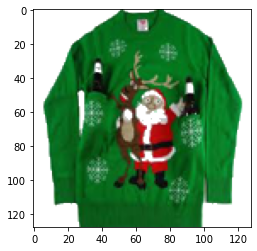

In [78]:
%%time

pixels = img_preprocessing(img = img)

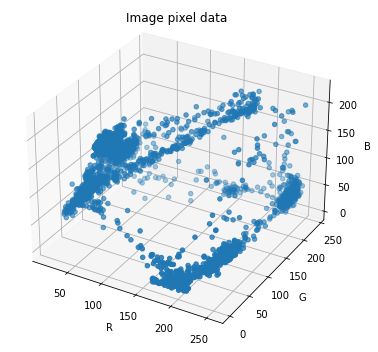

In [58]:
# parameter 'name' is the name of the plot to save.
# recomend to use what type or object of the image you are identifying
# default = 'photo'
draw_img_scatter(pixels, name = 'rainbow')

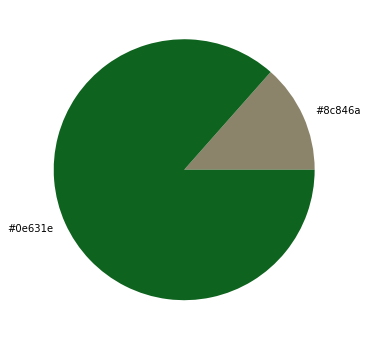

CPU times: total: 156 ms
Wall time: 124 ms


In [79]:
%%time

hex_colors, pixel_num = KMeans_color(pixels, n_cluster = 2, name = 'christmas', pie_yn = 1)

In [67]:
%%time

hex_colors, pixel_num = KMeans_color(pixels, n_cluster = 0, name = 'christmas', pie_yn = 0, sil_plot = 0)

2 clusters silhouette score = 0.8724640429133356
3 clusters silhouette score = 0.8054343173456346
4 clusters silhouette score = 0.46810358854501694
5 clusters silhouette score = 0.505182093537017
6 clusters silhouette score = 0.5237351229392895
7 clusters silhouette score = 0.4495442107661247
8 clusters silhouette score = 0.4303374783502401
9 clusters silhouette score = 0.43558657239357484
10 clusters silhouette score = 0.4362475617245834
11 clusters silhouette score = 0.3704769102687991
CPU times: total: 51.7 s
Wall time: 20.6 s


In [80]:
%%time

identified_color = color_identify_distance(rgb_data, hex_colors, pixel_num)

CPU times: total: 0 ns
Wall time: 2 ms


In [81]:
print(identified_color)

4    green
Name: name, dtype: object
